In [12]:
import numpy as np
from matplotlib import pyplot as plt
from tqdm import trange

$\frac{dU}{dt} + c\frac{dU}{dx} = 0$

In [13]:
# space-derivative approximation functions
def right_1(U, h):
    U_ = np.copy(U)
    U_[1:] = (U[1:] - U[:-1]) / h
    return U_
def right_2(U, h):
    U_ = np.copy(U)
    U_[2:] = (U[0:-2] - 4 * U[1:-1] + 3 * U[2:]) / h / 2.
    return U_
def weno_5(U, h):
    N = U.size
    C = np.array([[1./3., 5./6., -1./6.],
                  [-1./6., 5./6., 1./3.],
                  [1./3., -7./6., 11./6.]])
    Beta = np.zeros((3, N - 6))
    Beta[0, :] = 13./12. * (U[3:-3] - 2. * U[4:-2] + U[5:-1]) ** 2 + 1./4. * (3. * U[3:-3] - 4. * U[4:-2] + U[5:-1]) ** 2
    Beta[1, :] = 13./12. * (U[2:-4] - 2. * U[3:-3] + U[4:-2]) ** 2 + 1./4. * (U[2:-4] - U[4:-2]) ** 2
    Beta[2, :] = 13./12. * (U[1:-5] - 2. * U[2:-4] + U[3:-3]) ** 2 + 1./4. * (U[1:-5] - 4. * U[2:-4] + 3. * U[3:-3]) ** 2
    
    d = np.array([0.3, 0.6, 0.1])
    eps = 1e-20
    alpha = d / (eps + Beta.T) ** 2
    W = alpha.T / np.sum(alpha, axis = 1)
    
    U_R = np.zeros_like(U)
    U_R[3:-3] += W[0, :] * np.convolve(U[3:-1], C[0, ::-1], 'valid') + \
                 W[1, :] * np.convolve(U[2:-2], C[1, ::-1], 'valid') + \
                 W[2, :] * np.convolve(U[1:-3], C[2, ::-1], 'valid')
    U_big = np.zeros(N + 1)
    U_big[1:] = U_R
    return (U_big[1:] - U_big[:-1]) / h

from central_diference import generate_cd
cd_2 = generate_cd(2).get_cd_as_function()
cd_4 = generate_cd(4).get_cd_as_function()
cd_6 = generate_cd(6).get_cd_as_function()
cd_8 = generate_cd(8).get_cd_as_function()
cd_10 = generate_cd(10).get_cd_as_function()
cd_12 = generate_cd(12).get_cd_as_function()
cd_14 = generate_cd(14).get_cd_as_function()
cd_16 = generate_cd(16).get_cd_as_function()

In [14]:
# time-derivative approximation functions
def upwind(U, h, c, r, Deriv):
    dt = r * h
    return U - c * dt * Deriv(U, h), dt
from runge_kutta import runge_kutta_function
rk_2 = runge_kutta_function(2)
rk_3 = runge_kutta_function(3)
rk_4 = runge_kutta_function(4)
rk_5 = runge_kutta_function(5)
rk_7 = runge_kutta_function(7)
rk_8 = runge_kutta_function(8)
def runge_kutta_2(U, h, c, r, Deriv):
    dt = r * h
    #print(U)
    return rk_2(U, c * dt, Deriv, (-h,)), dt
def runge_kutta_3(U, h, c, r, Deriv):
    dt = r * h
    #print(U)
    return rk_3(U, c * dt, Deriv, (-h,)), dt
def runge_kutta_4(U, h, c, r, Deriv):
    dt = r * h
    #print(U)
    return rk_4(U, c * dt, Deriv, (-h,)), dt
def runge_kutta_5(U, h, c, r, Deriv):
    dt = r * h
    #print(U)
    return rk_5(U, c * dt, Deriv, (-h,)), dt
def runge_kutta_7(U, h, c, r, Deriv):
    dt = r * h
    #print(U)
    return rk_7(U, c * dt, Deriv, (-h,)), dt
def runge_kutta_8(U, h, c, r, Deriv):
    dt = r * h
    #print(U)
    return rk_8(U, c * dt, Deriv, (-h,)), dt

In [15]:
class Solver:
    def __init__(self, h, c, L, r, T = 100., pw = 6):
        self.h = h
        self.c = c
        self.L = L
        self.r = r
        self.T = T
        self.Nx = int(L / h)
        self.pw = pw
        self.U = np.zeros(self.Nx)
        self.U_ex = np.zeros(self.Nx)
    def initial(self):
        x0 = int(self.Nx / 2) - int(20 / self.h)
        x1 = x0 + int(40 / self.h)
        x = np.linspace(0, self.L, self.Nx)
        self.U[x0:x1] = np.abs(np.sin((x[x0:x1] - x[x0]) * np.pi / (x[x1] - x[x0])) ** self.pw)
        cTh = int(self.c * self.T / self.h)
        self.U_ex[x0 + cTh:x1 + cTh] = np.abs(np.sin((x[x0 + cTh:x1 + cTh] - x[x0 + cTh]) * np.pi / (x[x1 + cTh] - x[x0 + cTh])) ** self.pw)
    def solve(self, F, Deriv):
        #t = 0
        #while t < self.T:
        #    temp, dt, idx_l, idx_r = F(self.U, self.h, self.c, self.r, Deriv)
        #    self.U[idx_l : idx_r] = temp
        #    t += dt
        self.U, dt = F(self.U, self.h, self.c, self.r, Deriv)
        Nt = int(self.T / dt)
        for i in trange(Nt):
            if i == 0: continue
            self.U, dt = F(self.U, self.h, self.c, self.r, Deriv)
    def error(self):
        x0 = int(self.Nx / 2) - int(20 / self.h)
        x1 = x0 + int(40 / self.h)
        cTh = int(self.c * self.T / self.h)
        return np.sqrt(np.sum((self.U[x0 + cTh: x1 + cTh] - self.U_ex[x0 + cTh: x1 + cTh]) ** 2 * self.h))
        #return np.mean((self.U[x0 + cTh: x1 + cTh] - self.U_ex[x0 + cTh: x1 + cTh]) ** 2 * self.h)
    def draw(self, axs, ylabel = 'U'):
        x = np.linspace(0, self.L, self.Nx)
        x0 = int(self.Nx / 2) - int(20 / self.h)
        x1 = x0 + int(40 / self.h)
        cTh = int(self.c * self.T / self.h)
        axs.plot(x[x0 + cTh - 100: x1 + cTh + 100], self.U[x0 + cTh - 100: x1 + cTh + 100], label = ylabel);
        axs.plot(x[x0 + cTh - 100: x1 + cTh + 100], self.U_ex[x0 + cTh - 100: x1 + cTh + 100], '--', label = 'h = ' + str(self.h));
        axs.set_xlabel('x')
        axs.set_ylabel('y')
        axs.grid()
        axs.legend()

In [16]:
def init_H_as_power_of_2(n):
    H = np.array([2 ** -i for i in range(n)])
    return H

In [17]:
def least_squares_linear(x, y):
    # y = a * x + b
    n = x.size
    sx2 = np.sum(x ** 2)
    sx = np.sum(x)
    sy = np.sum(y)
    sxy = np.sum(x * y)
    d = n * sx2 - sx * sx
    da = n * sxy - sx * sy
    db = sx2 * sy - sx * sxy
    return da / d, db / d

In [18]:
def make_error_packs(H, c, L, r, deriv_t, deriv_x, T = 100., pw = 6, draw = False):
    N = len(H)
    #dt_size, dx_size = len(deriv_t), len(deriv_x)
    err_pack = []
    if draw: fig, axs = plt.subplots(N, 1, figsize = (10, 8))
    for dt in deriv_t:
        for dx in deriv_x:
            errs = np.zeros(N)
            for i, h in enumerate(H):
                solver = Solver(h, c, L, r, T, pw)
                solver.initial()
                solver.solve(dt, dx)
                errs[i] = solver.error()
                ylabel = str(dt).split(' ')[1] + '+' + str(dx).split(' ')[1]
                if draw: solver.draw(axs[i], ylabel)
            err_pack.append(errs)
    return err_pack

In [19]:
def plot_errors(H, errs_packs):
    plt.figure(figsize = (10, 10))
    plt.grid()
    plt.title('Errors')
    plt.xlabel('ln(h)')
    plt.ylabel('ln(err)')
    for err in errs_packs:
        a, b = least_squares_linear(np.log(H), np.log(err))
        plt.scatter(np.log(H), np.log(err), label = 'order = ' + str(a));
        plt.plot(np.log(H), a * np.log(H) + b, '--', color = 'black')
        plt.legend()
        #print(np.log(err[-2] / err[-1]) / np.log(2.))


100%|██████████| 200/200 [00:00<00:00, 737.74it/s]


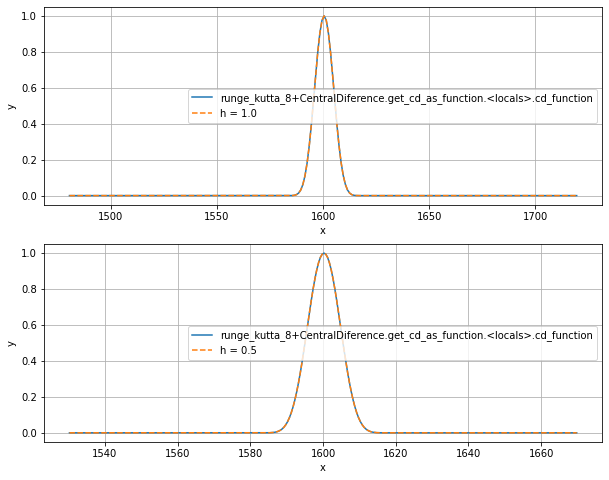

In [20]:
c = 1. 
L = 3000
r = 1.
#H = [0.125, 0.0625]
H = np.array([1, .5])
err_packs = make_error_packs(H, c, L, r, [runge_kutta_8], [cd_8], pw = 8, draw = True)

[array([9.10225568e-05, 3.83047659e-07])]


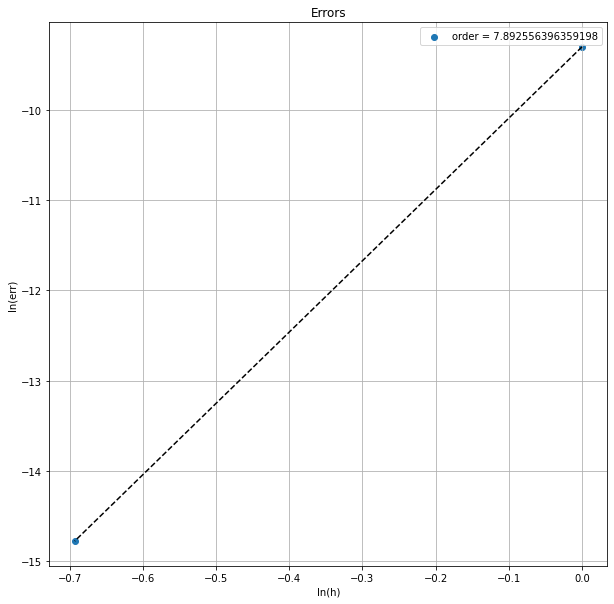

In [21]:
print(err_packs)
plot_errors(H, err_packs)